### Import Modules

In [20]:
# This code gives vehicles that are lane-changing in a constant history
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib nbagg

Simulation configuration

In [21]:
# Number of vehicles to keep track of, e.g. plot headways, positions of chosen vehicles
n_cars_plot = 4

## Lane-Changing Models

In [22]:
def prob_enter(headway, vel, density, t_cur, t_lc, beta=.9825):
    """Probability of a car entering any of the gaps inbetween vehicles

    :returns: boolean array, True if a car enters a gap
                             False if a car does not enter the gap
    """
    
    th = headway #np.divide(headway,vel)  # time headway
    
    #mu_lc = 2.850 #1.9802 - 32.7937*density
    mu_lc = 3.09
    sigma_lc = .3642
    
    mu_th = 2.9512 #2.05 - 48.53*density
    sigma_th = 0.4255
    
    # normalization constant
    C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
        * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
               (-2*sigma_th**2+2*sigma_lc**2)) \
        / np.sqrt(2*np.pi)
        
    p_appear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))
    
    #if (t_cur%t_lc)==0 and len(headway)<38:
    if (t_cur%t_lc)==0:
        #return np.random.rand(len(headway)) < p_appear * t_lc / beta
        return np.random.rand(len(headway)) < p_appear
    else:
        return [False]*len(headway)

In [23]:
def prob_exit(headway, vel, density, t_cur, t_lc, beta=.9825):
    """Probability of cars in the lane exitting

    :returns: boolean array, True if a car exits the lane
                             False if a car does not exit the lane
    """
    
    th = headway #np.divide(headway,vel)  # time headway
    
    mu_lc = 2.7962 #2.0718 - 51.96*density
    sigma_lc = 0.4176
    
    mu_th = 2.9512 #2.05 - 48.53*density
    sigma_th = 0.4255
    
    # normalization constant
    C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
        * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
               (-2*sigma_th**2+2*sigma_lc**2)) \
        / np.sqrt(2*np.pi)
        
    p_disappear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))
    
    if (t_cur%t_lc)==0 and len(headway)>4:
        # return np.random.rand(len(headway)) < p_disappear * t_lc / beta
        return np.random.rand(len(headway)) < p_disappear
    else:
        return [False]*len(headway)

## Car-Following Model

In [24]:
def car_following_OVM(y, t, params, y_minus_tau):
    """Defines car-following behavior of driver-vehicle units.
       Behvaior here is specified by the Optimal Velocity Model (OVM)
    
    :y: state of the system
        - first half of the array represents the headway of the cars, ordered in decreasing position
        - second half of the array represents the velocity of the cars, ordered as they are in the position half
    :t: time interval
    :params : parameters of the OVM car-following model
              - params['alpha']  : headway gain
              - params['beta']   : relative velocity gain
              - params['tau']    : driver reaction time [s]
              - params['v_max']  : maximum velocity [m/s]
              - params['h_go']   : go headway [m]
              - params['h_st']   : stop headway [m]
    :y_minus_tau: state of the system tau seconds ago
    
    :returns: dydt - derivative of the states (y)
    """
    
    dydt = np.zeros(len(y))
    n = int(len(y)/2)
    
    for i in range(n):
        if i==0:
            vl = y[-1]                      # velocity of lead vehicle
            vl_minus_tau = y_minus_tau[-1]  # lead velocity tau seconds ago
        else:
            vl = y[n+i-1]
            vl_minus_tau = y_minus_tau[n+i-1]
    
        v = y[n+i]                      # velocity of current vehicle
        h = y_minus_tau[i]              # headway of current vehicle
        v_minus_tau = y_minus_tau[n+i]  # velocity of current vehicle tau seconds ago
        
        if h <= params['h_st']:
            V = 0
        elif h < params['h_go']:
            V = params['v_max']/2*(1-np.cos(np.pi*(h-params['h_st'])/(params['h_go']-params['h_st'])))
        else:
            V = params['v_max']
            
        dydt[i] = vl - v
        dydt[n+i] = params['alpha']*(V-v_minus_tau) + params['beta']*(vl_minus_tau-v_minus_tau)
    
    return(dydt)

## Ring Road

In [25]:
class ring_road():
    """
    Simulation of vehicles in a circular lane following the IDM model.
    Vehicles are allowed to enter and exit the lane according to the probability "prob_enter" and "prob_exit"
    Certain vehicle units of your choosing can be held constant in the model for analysis purposes
    """
    
    def __init__(self, params, n_cars, x_init, v_init, ind_cars_const):
        """Instantiates the class with the car-following model parameters
           Initializes road with a set of vehicles with inital positions and velocities
           Specifies vehicles that should not be allowed to exit the road (may be equal to zero)
        
        :params         : parameters of the car-following model, MUST CONTAIN lr and lc
                           - params['lc'] : average vehicle length [m]
                           - params['lr'] : length of the circular road [m]
        :n_cars         : initial number of cars on the road [unitless]
        :x_init         : inital position of each car in the set [m]
        :v_init         : initial velocity of each car in the set [m/s]
        :ind_cars_const : index of cars in the set that should be held constant (length equal to n_cars_const)
        """
        # car-following parameters
        self.params = params
        
        # parameters that are crucial for simulation
        self.lc  = params['lc']
        self.lr  = params['lr']
        self.tau = params['tau']
        
        # initial conditions of vehicles
        self.n_cars = n_cars
        self.x_init = x_init
        self.v_init = v_init
        self.h_init = np.append(-(x_init[-1]-x_init[0])+params['lr'], x_init[1:]-x_init[:-1]) - params['lc']
        
        # cars that cannot exit the road
        self.ind_cars_const = ind_cars_const
    
    
    def simulate(self, dt, t_final, t_lc=0):
        if t_lc == 0:
            t_lc = dt
        n_cars_const = len(self.ind_cars_const)
        
        # initialize empty dataframe to collect lane-change data
        lane_change_df = pd.DataFrame(columns=('time', 'velocity', 'lead_velocity', 'lag_velocity',
                                               'distance_headway', 'type'))
        
        # store constant cars in the first n columns
        ind_variable_cars = np.arange(self.n_cars)
        ind_variable_cars = ind_variable_cars[np.invert(np.in1d(ind_variable_cars,self.ind_cars_const))]
        ind = np.append(self.ind_cars_const, ind_variable_cars).astype(int)
        
        # reorganize inital conditions given new index arrangement
        y0 = np.append(self.h_init[ind], self.v_init[ind])
        
        # time range from 0 to t_final
        t = np.arange(0, t_final+dt, dt)
        
        # initialize variables of interest
        pos = np.zeros((len(t), int(len(y0)/2)))
        pos[0,:] = self.x_init
        sol = np.zeros((len(t), len(y0)))
        sol[0,:] = y0
        
        n_cars_tot = self.n_cars  # total number of cars to be in the lane
        n_cars_cur = np.append(self.n_cars, np.zeros(len(t)-1))  # current number of cars in the lane
        ind_cars = np.arange(self.n_cars)
        ind_cars = ind_cars[np.argsort(self.x_init[ind])][::-1]  # indeces of the cars currently in the lane
                                                                 # organized in decreasing order of position
        
        for i in range(1,len(t)):
            ########## calculate next position and velocity of current cars in lane ##########
            if i%1000==0:
                print(i)
            sol_i = odeint(car_following_OVM, sol[i-1, np.append(ind_cars, ind_cars+n_cars_tot)], [0,dt],
                           args=(self.params,sol[max(0,i-int(self.tau/dt)), np.append(ind_cars, ind_cars+n_cars_tot)]))
            
            # store new position and velocity data
            sol[i,np.append(ind_cars, ind_cars+n_cars_tot)] = sol_i[-1,:]
            sol[i,:] = sol[i,:].clip(min=0)
            
            # headway of each car currently in the lane
            headway_cur = sol[i, ind_cars]
            
            # velocity of each car currently in the lane
            vel_cur = sol[i, ind_cars+n_cars_tot]
            
            # store new headway data
            pos[i,ind_cars] = pos[i-1,ind_cars]+vel_cur*dt
            
            
            ######## check for situations of lane changes given velocity and headway #########            
            
            # density of lane
            density = 0.02# n_cars_cur[i-1]/self.lr
                        
            # determine which gaps accept new cars
            enter = prob_enter(headway_cur, vel_cur, density, t[i], t_lc)
            # determine which cars exit the lane
            exit = prob_exit(headway_cur, vel_cur, density, t[i], t_lc)
            # ensure that cars that are constant do not exit the lane
            exit = np.logical_and(exit, np.logical_not(np.in1d(ind_cars,np.arange(n_cars_const))))
            
            
            ################### collect exit data in lane-change dataframe ###################
            
            if sum(exit)>0:
                ind_exit = np.where(exit)[0]
                
                exit_time = t[i]*np.ones(sum(exit))
                exit_vel = vel_cur[exit]
                exit_headway  = headway_cur[exit]
                exit_type = ["Exit"]*sum(exit)
                if exit[0]:
                    exit_lead_vel = np.append(vel_cur[-1:], vel_cur[np.where(exit)[0][1:]-1])
                else:
                    exit_lead_vel = vel_cur[np.where(exit)[0]-1]
                    
                if exit[-1]:
                    # add headways to lagging vehicle of exitted vehicles
                    sol[i, np.append(ind_cars[ind_exit[:-1]+1],ind_cars[0])] += sol[i, ind_cars[ind_exit]]
                else:
                    # add headways to lagging vehicle of exitted vehicles
                    sol[i, ind_cars[ind_exit+1]] += sol[i, ind_cars[ind_exit]]
            
                df_exit = pd.DataFrame({'time':exit_time, 'velocity':exit_vel, 'lead_velocity':exit_lead_vel,
                                        'distance_headway':exit_headway, 'type':exit_type})
                lane_change_df = lane_change_df.append(df_exit, ignore_index=True)
            
            
            ############## update variables given cars that entered and/or exit ##############
            
            if sum(enter)>0:
                ind = np.where(enter)[0]
                
                # calculate the velocity of the new vehicle ()
                v_new = sol[i, ind_cars[ind]+n_cars_tot]
                
                # calculate the headway of the new vehicle and the vehicle behind it
                h_new = 0.5*sol[i, ind_cars[ind]]
                h_lag_new = sol[i, ind_cars[ind]] - h_new
                sol[i, ind_cars[ind]] = h_lag_new
                
                # calculate the position of the new vehicles
                pos_new = pos[i, ind_cars[ind]]+h_lag_new

                # add columns to sol to compensate for the presence of new vehicles
                sol = np.insert(sol, [n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                sol = np.insert(sol, [sum(enter)+n_cars_tot+n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                
                # add initial data of new vehicles into sol
                sol[np.arange(i-int(self.tau/dt),i+1)][:,np.arange(sum(enter))+n_cars_const] = \
                    np.array([h_new]*len(np.arange(i-int(self.tau/dt),i+1)))
                sol[np.arange(i-int(self.tau/dt),i+1)][:,np.arange(sum(enter))+n_cars_tot+sum(enter)+n_cars_const] = \
                    np.array([v_new]*len(np.arange(i-int(self.tau/dt),i+1)))
                
                # add columns to position to compensate for the presence of new vehicles
                pos = np.insert(pos, [n_cars_const], np.zeros((pos.shape[0], sum(enter))), axis=1)
                
                # update data in headway matrix to account for changes
                pos[i, np.arange(sum(enter))+n_cars_const] = pos_new
                
                # update lane-change dataframe with cars that entered
                enter_time = t[i]*np.ones(sum(enter))
                enter_type = ["Enter"]*sum(enter)
                df_enter = pd.DataFrame({'time':enter_time, 'velocity':v_new, 'lead_velocity':v_new,
                                         'distance_headway':h_new, 'type':enter_type})
                lane_change_df = lane_change_df.append(df_enter, ignore_index=True)
            
            # update indeces (whether change occured or not), and add cars (if change occured)
            exit = np.logical_or(exit, np.in1d(ind_cars,np.arange(n_cars_const)))
            ind_cars = np.append(np.append(np.arange(n_cars_const), np.arange(sum(enter))+n_cars_const),
                                 ind_cars[np.invert(exit)]+sum(enter))
            # order the indeces by position
            ind_cars = ind_cars[np.argsort(pos[i, ind_cars])[::-1]]
            
            n_cars_tot += sum(enter)
            n_cars_cur[i] = n_cars_cur[i-1] + sum(enter) - sum(exit) + n_cars_const
            
            
        pos_rad = np.divide(pos, self.lr) * 2*np.pi  # position in terms of radians
        pos_absolute = pos  # absolute position of every car, in meters
        headway = sol[:,:int(sol.shape[1]/2)]  # headway of every cars at every point in time
        vel = sol[:,int(sol.shape[1]/2):]  # velocity of every cars at every point in time, 0 if car is not avaialable
        
        return(pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur)

# Main

## Initialization

In [26]:
# define parameters of interest for the car following model
params = {'alpha':0.6, 'beta':0.9, 'tau':0.4, 'v_max':30, 'h_go':35, 'h_st':5, 'lc':0, 'lr':230}

# specify initial conditions
n_cars = 12  # number of cars
x_init = t = np.linspace(0, float(params['lr'])-float(params['lr'])/n_cars, n_cars)  # initial position of cars
v_init = 10*np.ones(n_cars)  # initial velocity of cars

# indeces of cars that do not change lanes
ind_cars_const = np.array([])

# initialize model
model = ring_road(params, n_cars, x_init, v_init, ind_cars_const)

# Simulation

In [27]:
dt = 0.025        # update time [s]
t_final = 1000  # simulation time [s]

## begin simulation
t1 = time.time()
pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur = model.simulate(dt, t_final, t_lc=1)
t2 = time.time()

print("Simulation Time:", t2-t1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
Simulation Time: 12.134921073913574


## Visualization

### Video

<IPython.core.display.Javascript object>


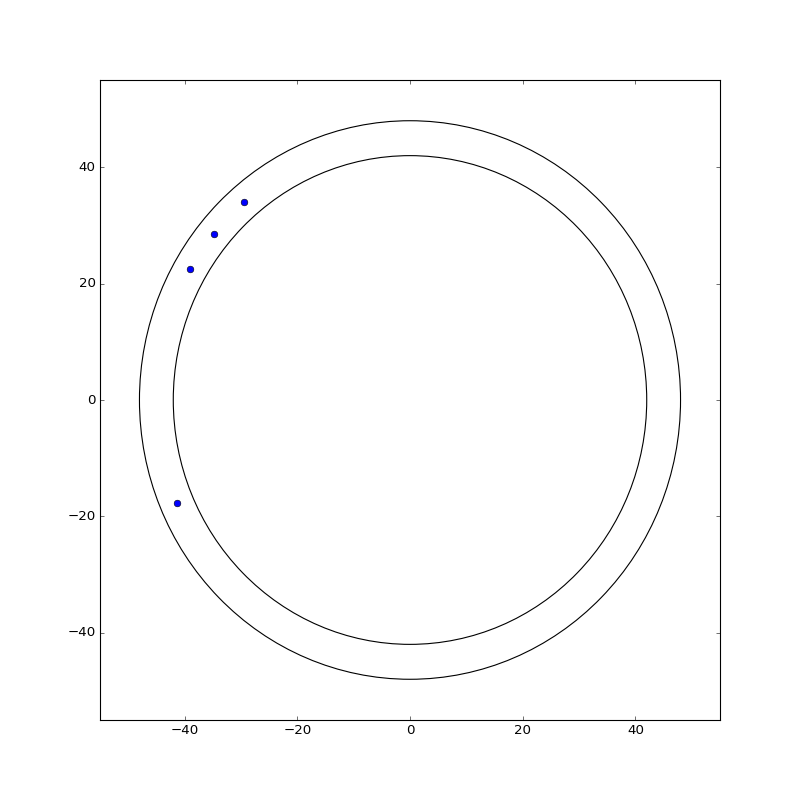

In [29]:
import time

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# initial x and y data
x = 45 * np.cos(pos_rad)
y = 45 * np.sin(pos_rad)

li1, = ax.plot(x[0,4:], y[0,4:], 'o')
li2, = ax.plot(x[0,:4], y[0,:4], 'o', c='r')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(1,x.shape[0],10):
    # set the new data
    li1.set_xdata(x[i,pos_rad[i,:]!=0])
    li1.set_ydata(y[i,pos_rad[i,:]!=0])
    li2.set_xdata(x[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    li2.set_ydata(y[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    
    fig.canvas.draw()
    #time.sleep(0.05)

### Position Profile (Time-space diagram)

In [9]:
pos_absolute.shape

(20001, 142)

<IPython.core.display.Javascript object>


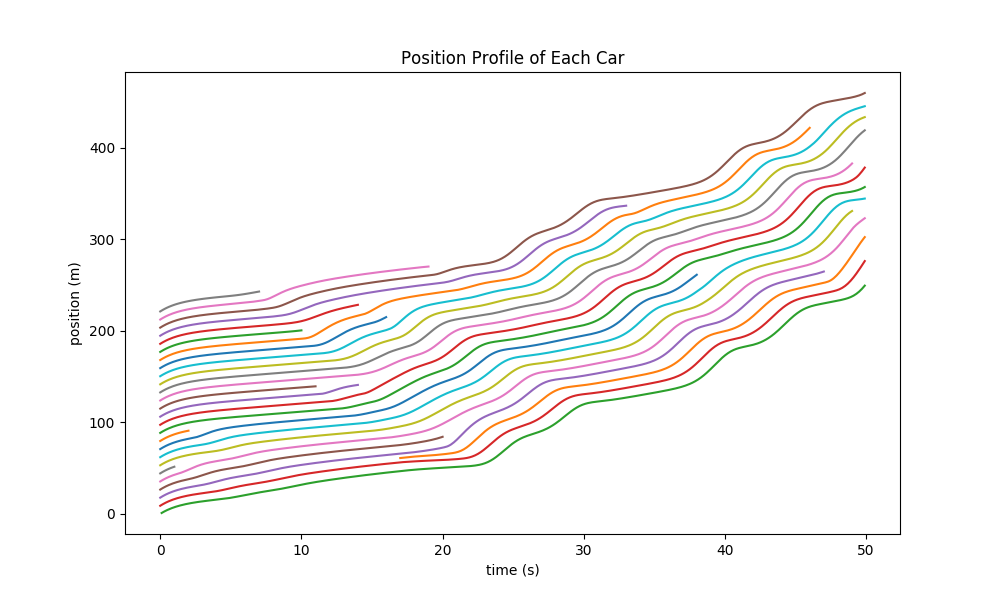

In [27]:
# Plot all cars at once, but for a snippet of the overall simulation run
step_min = 0
step_max = 500

t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(10,6))

# i is each vehicle that ever exists in the simulation
for i in range(int(pos_absolute.shape[1])):
    valid_ind = pos_absolute[step_min:step_max,i]!=0
    plt.plot(t[valid_ind], pos_absolute[valid_ind][:,i])

plt.title("Position Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

### Headway Profile (Convergence plot)

In [16]:
print("Average number of cars (nbar):", np.average(n_cars_cur))
# TODO compute the equilibrium headway and velocity at nbar
print("h_nbar^*:")
print("v_nbar^*:")

Average number of cars (nbar): 5.29796755081
h_nbar^*:
v_nbar^*:


<IPython.core.display.Javascript object>


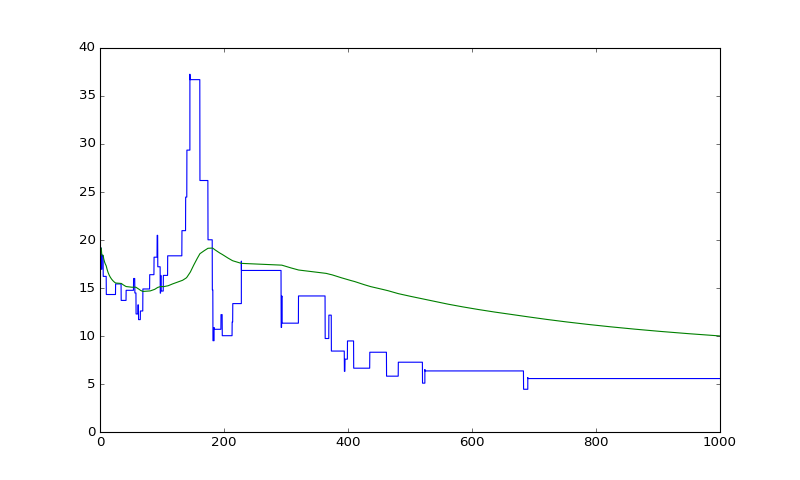

<IPython.core.display.Javascript object>


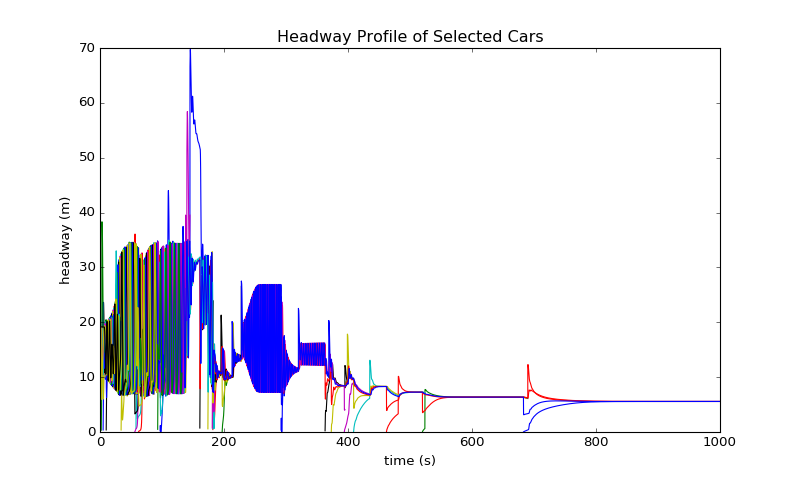

In [17]:
t = np.arange(0, t_final+dt, dt)

# calculate average headway
avg_headway = np.zeros(headway.shape[0])
convg_headway = np.zeros(headway.shape[0])

for i in range(avg_headway.shape[0]):
    avg_headway[i] = np.sum(headway[i,:])/sum(headway[i,:]!=0)
    convg_headway[i] = np.average(avg_headway[0:i])
    
plt.figure(figsize=(10,6))

plt.plot(t[avg_headway!=0], avg_headway[avg_headway!=0])
plt.plot(t[convg_headway!=0], convg_headway[convg_headway!=0])

plt.figure(figsize=(10,6))

for i in range(headway.shape[1]):
    plt.plot(t[headway[:,i]!=0], headway[headway[:,i]!=0][:,i])

plt.title("Headway Profile of Selected Cars")
plt.xlabel('time (s)')
plt.ylabel('headway (m)')
plt.show()

### Velocity Profile

3.89563011902


<IPython.core.display.Javascript object>


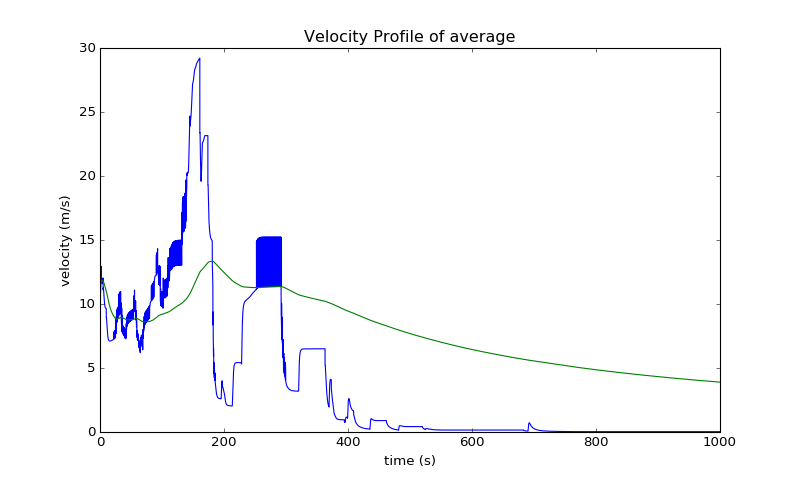

<IPython.core.display.Javascript object>


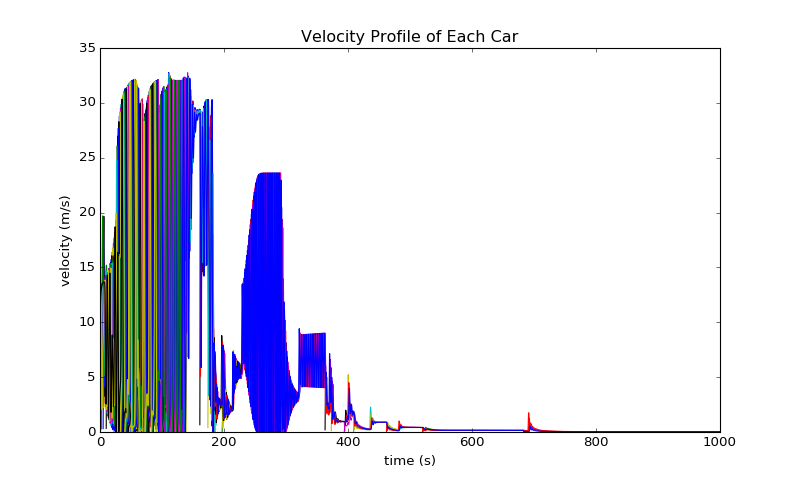

In [18]:
t = np.arange(0, t_final+dt, dt)

avg_vel = np.zeros(vel.shape[0])
convg_vel = np.zeros(vel.shape[0])
for i in range(avg_vel.shape[0]):
    avg_vel[i] = np.sum(vel[i,:])/sum(vel[i,:]!=0)
    convg_vel[i] = np.average(avg_vel[0:i])

print(convg_vel[-1])
plt.figure(figsize=(10,6))
plt.plot(t[avg_vel!=0], avg_vel[avg_vel!=0])
plt.plot(t[convg_vel!=0], convg_vel[convg_vel!=0])

plt.title("Velocity Profile of average")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()    
    
plt.figure(figsize=(10,6))

for i in range(vel.shape[1]):
    plt.plot(t[vel[:,i]!=0], vel[vel[:,i]!=0,i])

plt.title("Velocity Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()

### Number of Cars vs. Time

4.846


<IPython.core.display.Javascript object>


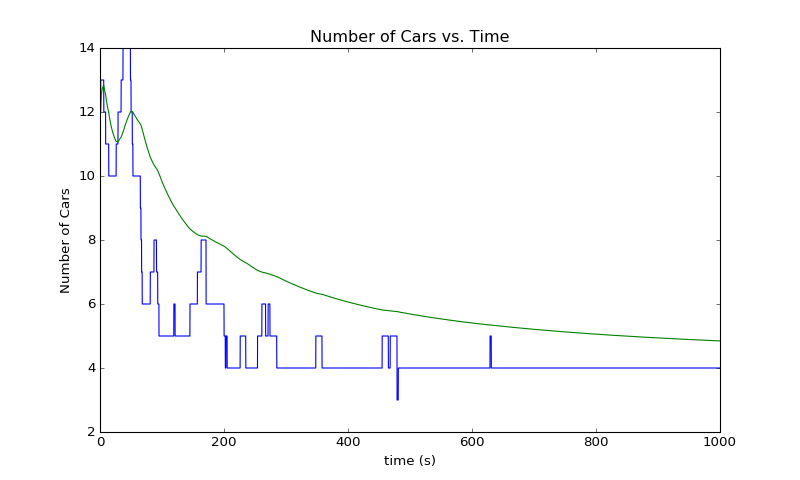

In [28]:
#EVL = params['s0']+params['lc']   # effective vehicle length
#max_occupancy = params['lr']/EVL  # maximum number of cars on the road

t = np.arange(0, t_final+dt, dt)


# calculate the average number of cars over time
avg_cars = np.zeros(n_cars_cur.shape[0])
for i in range(avg_cars.shape[0]):
    avg_cars[i] = np.average(n_cars_cur[0:i])
    
print(avg_cars[-1])  


plt.figure(figsize=(10,6))

plt.plot(t,n_cars_cur)
plt.plot(t,avg_cars)

# max occupancy is over 160, I recommend not putting
#plt.plot(t,max_occupancy*np.ones(len(t)))

plt.title("Number of Cars vs. Time")
plt.xlabel('time (s)')

plt.ylabel('Number of Cars')
plt.show()

In [16]:
lane_change_df

,distance_headway,lag_velocity,lead_velocity,time,type,velocity
0,4.423077,NaN,1.203059,10.0,Enter,1.203059
1,8.031078,NaN,0.691124,22.5,Exit,0.713690
2,4.377288,NaN,1.135349,27.5,Enter,1.135349
3,8.122903,NaN,0.648399,35.0,Exit,0.721021
4,4.010411,NaN,0.757522,40.0,Enter,0.757522
5,9.076056,NaN,1.138385,45.0,Exit,1.320104
6,7.813516,NaN,0.533337,50.0,Exit,0.581414
7,10.124520,NaN,1.896648,55.0,Exit,2.411174
8,9.173850,NaN,0.687546,55.0,Exit,1.030765
9,4.819632,NaN,1.896648,55.0,Enter,1.896648


In [17]:
th = np.arange(0,100,0.1)

mu_lc = 3 #1.9802 - 32.7937*density
sigma_lc = 0.4047

mu_th = 2.9699 #2.05 - 48.53*density
sigma_th = 0.455

# normalization constant
C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
    * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
           (-2*sigma_th**2+2*sigma_lc**2)) \
    / np.sqrt(2*np.pi)

p_appear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))    
    
mu_lc = 2.8202 #2.0718 - 51.96*density
sigma_lc = 0.44

mu_th = 2.9699 #2.05 - 48.53*density
sigma_th = 0.455

# normalization constant
C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
    * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
           (-2*sigma_th**2+2*sigma_lc**2)) \
    / np.sqrt(2*np.pi)

p_disappear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))

plt.figure()
plt.plot(nc,p_disappear)
plt.plot(nc,p_appear)
plt.legend(['disappear','appear'])
plt.xlim([0,100])
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'nc' is not defined

In [ ]:
nc = 230/th

In [ ]:
nc

In [ ]:
p_appear[11*10]

In [46]:
a = np.array([1,2,3])

b = np.array([a]*3)

In [50]:
b[[1,2]][:,1]

array([2, 2])